## Import

In [1]:
import random
import pandas as pd
import umap
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from recoxplainer.config import cfg
from recoxplainer.data_reader.data_reader import DataReader
from recoxplainer.models.emf_model import EMFModel

from recoxplainer.recommender import Recommender 
from recoxplainer.evaluator import Splitter, Evaluator, ExplanationEvaluator
from recoxplainer.explain import EMFExplainer

/opt/anaconda3/envs/recoxplainer2/lib/python3.6/site-packages/umap/__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


## Import data

In [2]:
data = DataReader(**cfg.ml100k)
data.make_consecutive_ids_in_dataset()
sp = Splitter()
train, test = sp.split_leave_n_out(data, frac=0.1)

## Model training & recommending

In [3]:
emf = EMFModel(**cfg.model.emf)

In [4]:
emf.fit(train)

  0%|          | 0/10 [00:00<?, ?it/s]

True

In [5]:
rec = Recommender(train, emf)
rec = rec.recommend_all()

Recommending for users:   0%|          | 0/943 [00:00<?, ?it/s]

## Generating Explanations

In [6]:
explanations = EMFExplainer(emf, rec, data)

In [7]:
res = explanations.explain_recommendations()

Computing explanations:   0%|          | 0/9430 [00:00<?, ?it/s]

In [8]:
ex = ExplanationEvaluator(train.num_user)

Evaluationg an explanation:

In [9]:
ex.mean_explaianable_precision(res, emf.explainability_matrix)

0.4562036055143171

In [10]:
def plot_model(model, dt, user_X):
    
    dim_red_model = umap.UMAP().fit_transform(model.item_embedding())
    dim_red_model_usr = umap.UMAP().fit_transform(model.user_embedding())

    rated_items = dt.dataset[dt.dataset.userId == user_X].itemId

    item_emb_for_user_X = pd.DataFrame.from_dict({
        'x': dim_red_model[:,0],
        'y': dim_red_model[:,1],
        'expl': model.explainability_matrix[user_X, :]})

    item_emb_for_user_X = item_emb_for_user_X.sort_values(by=['expl'])

    sns.scatterplot(data=item_emb_for_user_X, x="x", y="y", hue="expl")
    
    plt.scatter(dim_red_model[rated_items,0], 
            dim_red_model[rated_items,1], 
            marker='o', c='#c3e0f4')

    plt.scatter(dim_red_model_usr[user_X,0], 
            dim_red_model_usr[user_X,1], 
            marker='X', s=100, c='#419ede')

In [11]:
rand_usr = random.choice(data.dataset.userId.unique())

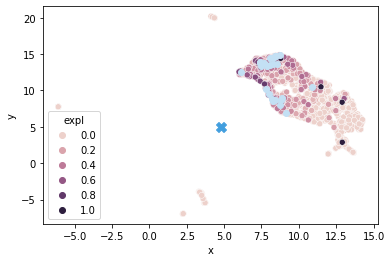

In [13]:
plot_model(emf, train, rand_usr)